In [52]:
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from numpy import arange, sin, pi, random
from scipy.stats import norm
from sklearn.metrics import mean_squared_error

In [101]:
np.random.seed(1234)

sequence_length = 100
epochs = 50
batch_size = 100

In [3]:
def gen_wave():
    """ Generate a synthetic wave by adding up a few sine waves and some noise return: the final wave
    """
    t = np.arange(0.0, 20.0, 0.01)
    wave1 = sin(2 * 2 * pi * t)
    noise = random.normal(0, 0.2, len(t))
    wave1 = wave1 + noise
    wave2 = sin(2 * pi * t)
     
    t_rider = arange(0.0, 0.5, 0.01)
    wave3 = 0.5*sin(10 * pi * t_rider)
     
    insert = round(0.9 * len(t))
    wave1[insert:insert + 50] = wave1[insert:insert + 50] + wave3
    wave1[1700] = wave1[1700] + 0.65
    return wave1 + wave2

In [4]:
data = gen_wave()

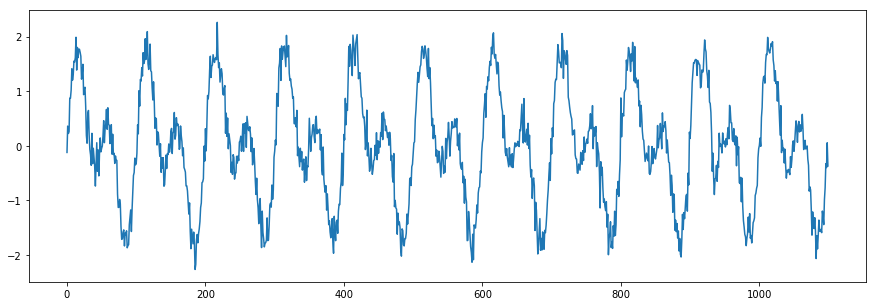

In [17]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

plt.plot(data[900:])
plt.show()

In [9]:
from pandas.plotting import lag_plot
import pandas as pd 

In [13]:
t_data = pd.core.series.Series(data)

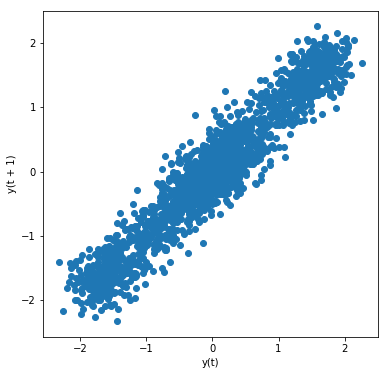

In [15]:
plt.figure(figsize=(6, 6))
lag_plot(t_data)
plt.show()

In [22]:
m_values = pd.DataFrame(data)
dataframe = pd.concat([m_values.shift(1), m_values], axis=1)
dataframe.corr()

,0,0
0,1.000000,0.957143
0,0.957143,1.000000


In [19]:
from pandas.plotting import autocorrelation_plot

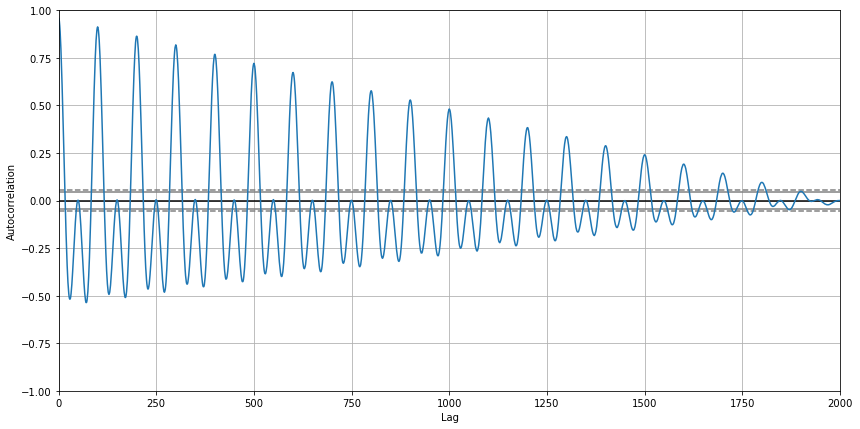

In [20]:
plt.figure(figsize=(14, 7))
autocorrelation_plot(t_data)
plt.show()

In [28]:
from statsmodels.graphics.tsaplots import plot_acf

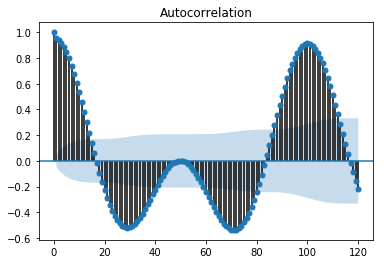

In [37]:
plot_acf(t_data, lags=120)
plt.show()

## Auto Regression

In [21]:
from statsmodels.tsa.ar_model import AR

/home/kaifa/Softs/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [23]:
train = data[:1500]
test  = data[1500:]

In [27]:
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 24
Coefficients: [-0.00067489  0.31142862  0.26380823  0.23880641  0.22698263  0.13486638
  0.10239574  0.0301188  -0.05347371 -0.05301853 -0.0117554  -0.09005787
 -0.07734769 -0.04740201 -0.05070274 -0.07789644 -0.0406478  -0.02750755
 -0.00949551  0.01721971  0.01515596  0.03145027  0.04556037  0.01219212
  0.04634901]


In [38]:
window = model_fit.k_ar
coef = model_fit.params

### Check the performance over the whole dataset

In [50]:
# walk forward over time steps
history = data[:window]
test  = data[window:] #go through the whole dataset
history= list(history)
print(len(history), len(test))

24 1976


In [53]:
predictions = list()
for t in range(len(test)):
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * history[window-d-1] # coefficients from t-1 to t-n
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    history = history[1:]
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 0.062


In [80]:
def AR_plot(test, predictions, m_min, m_max):
    test = test[m_min:m_max]
    predictions = predictions[m_min:m_max]
    
    plt.figure(figsize=(15,10))
    plt.figure(1)
    plt.subplot(311)
    plt.title("Actual Test Signal w/Anomalies")
    plt.plot(test, 'b')
    plt.subplot(312)
    plt.title("Predicted Signal")
    plt.plot(predictions, 'g')
    plt.subplot(313)
       
    error_vectors = test - predictions
    mean = np.mean(error_vectors)
    std = np.std(error_vectors)
    p_values = norm(loc=mean, scale=std).logpdf(error_vectors)
    plt.title("log PD")
    plt.plot(p_values, 'r')    
    plt.show()

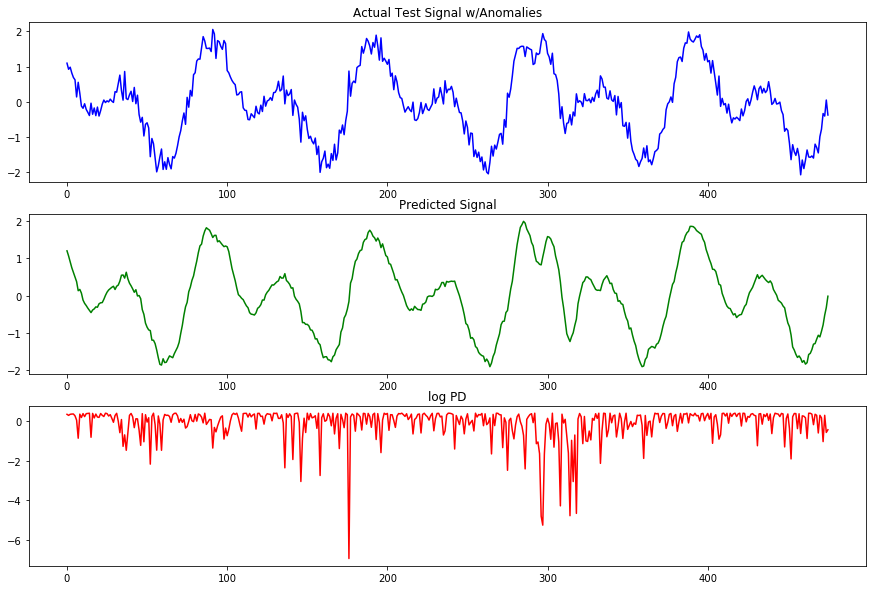

In [81]:
AR_plot(test, predictions, 1500, 2000)

## Feed the residuals to LSTM

In [82]:
residuals = predictions - test

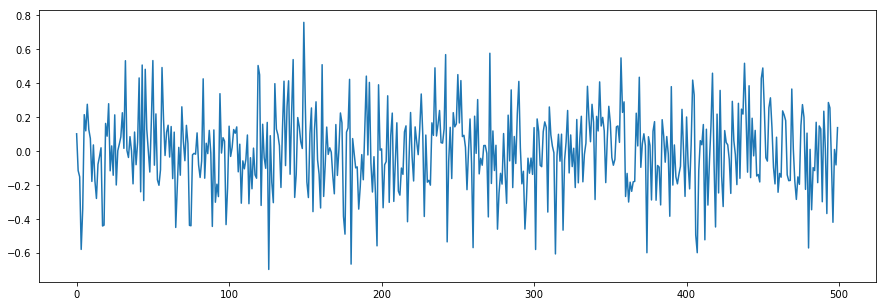

In [87]:
plt.figure(figsize=(15, 5))
plt.plot(residuals[500:1000])
plt.show()

In [94]:
residuals.shape

(1976,)

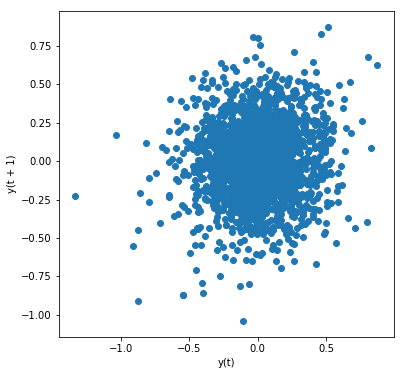

In [90]:
t_residuals = pd.core.series.Series(residuals)
plt.figure(figsize=(6, 6))
lag_plot(t_residuals)
plt.show()

In [95]:
def z_norm(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

In [97]:
def get_split_prep_data(data, train_start, train_end, test_start, test_end):
    
    print("Length of Data", len(data))
    # train data
    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)
 
    X_train = result[:, :-1]
    y_train = result[:, -1]
    
    # test data
    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  #
    result, result_mean = z_norm(result)
    X_test = result[:, :-1]
    y_test = result[:, -1]
      
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))
    
    return X_train, y_train, X_test, y_test

In [98]:
def build_model():
    model = Sequential()
    layers = {'input': 1, 'hidden1': 32, 'hidden2': 64, 'hidden3': 64, 'output': 1}

    model.add(LSTM(return_sequences=True, units=layers['hidden1'], input_shape=(sequence_length - 1, layers['input'])))
    model.add(Dropout(0.2))

    model.add(LSTM(layers['hidden2'], return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(layers['hidden3'], return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))
    model.add(Activation("selu"))

    start = time.time()
    model.compile(loss="mse", optimizer="adam")
    print ("Compilation Time : ", time.time() - start)
    return model

In [109]:
X_train, y_train, X_test, y_test = get_split_prep_data(residuals, 0, 1400, 1500, 1976)
 
print ('\nData Loaded. Compiling...\n')
model = build_model()

print("Training...")
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Length of Data 1976
Shape X_train (1300, 99, 1)
Shape X_test (376, 99, 1)

Data Loaded. Compiling...

Compilation Time :  0.038742780685424805
Training...
Train on 1040 samples, validate on 260 samples
Epoch 1/50
1040/1040 [==============================] - 8s - loss: 0.9771 - val_loss: 1.0356
Epoch 2/50
1040/1040 [==============================] - 5s - loss: 0.9710 - val_loss: 1.0302
Epoch 3/50
1040/1040 [==============================] - 5s - loss: 0.9687 - val_loss: 1.0274
Epoch 4/50
1040/1040 [==============================] - 4s - loss: 0.9617 - val_loss: 1.0150
Epoch 5/50
1040/1040 [==============================] - 4s - loss: 0.9516 - val_loss: 0.9898
Epoch 6/50
1040/1040 [==============================] - 4s - loss: 0.9470 - val_loss: 0.9931
Epoch 7/50
1040/1040 [==============================] - 5s - loss: 0.9442 - val_loss: 0.9827
Epoch 8/50
1040/1040 [==============================] - 4s - loss: 0.9386 - val_loss: 0.9799
Epoch 9/50
1040/1040 [==============================] 

In [110]:
predicted = model.predict(X_test)
predicted = np.reshape(predicted, (predicted.size,))

In [111]:
def m_plot(predicted, y_test):
    plt.figure(figsize=(15,10))
    plt.figure(1)
    plt.subplot(311)
    plt.title("Actual Test Signal w/Anomalies")
    plt.plot(y_test[:len(y_test)], 'b')
    plt.subplot(312)
    plt.title("Predicted Signal")
    plt.plot(predicted[:len(y_test)], 'g')
    plt.subplot(313)

    error_vectors = y_test - predicted
    mean = np.mean(error_vectors)
    std = np.std(error_vectors)
    p_values = norm(loc=mean, scale=std).logpdf(error_vectors)
    plt.title("log PD")
    plt.plot(p_values, 'r')
        
    plt.show()

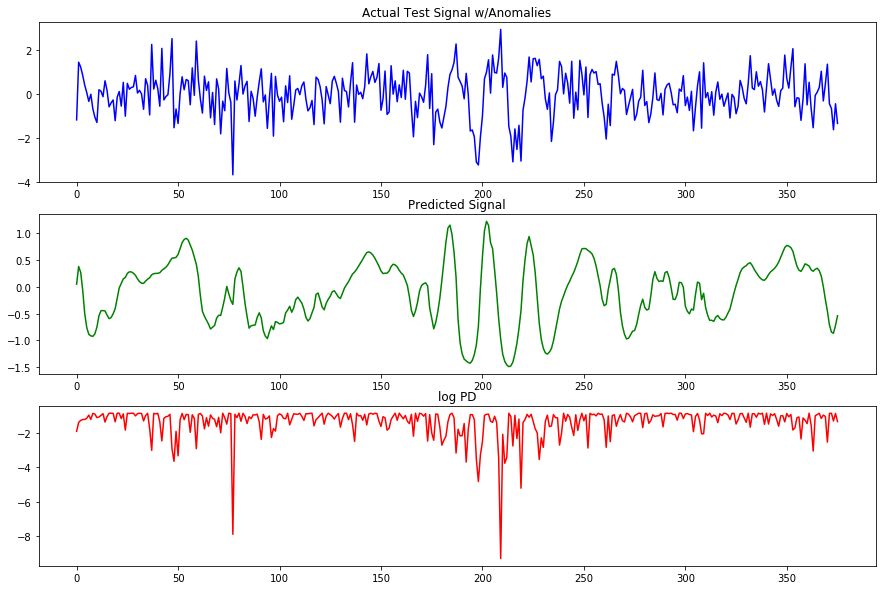

In [112]:
m_plot(predicted, y_test)